In [1]:
'''
%pip install kagglehub

import kagglehub

#Download latest version
path = kagglehub.dataset_download("yuanyuwendymu/airline-delay-and-cancellation-data-2009-2018")

print("Path to dataset files:", path)

%pip install pandas
%pip install numpy
'''

In [47]:
import pandas as pd
import numpy as np

df=pd.read_csv('2013.csv')

Let's start working with the 2013's data. Let's check at first which features it has by printing out one of the rows and then checking the dataset's dimensions.

In addition, there are many times in the military time format 'HHMM'. We will convert them to 'HH:MM' format.

In [48]:
def convert_to_time_format(value):
    if pd.isna(value):
        return pd.NaT
    value = int(value)  # In case it's stored as float
    hours = value // 100
    minutes = value % 100
    return f"{hours:02}:{minutes:02}"

time_columns = ['CRS_DEP_TIME', 'DEP_TIME', 'WHEELS_OFF', 'WHEELS_ON', 'CRS_ARR_TIME', 'ARR_TIME']
# Selecting the columns that should be transformed

for col in time_columns:
    df[col] = df[col].apply(convert_to_time_format) # Applying changes

In [49]:
# Convert CANCELLED and DIVERTED to boolean
boolean_columns = ['CANCELLED', 'DIVERTED']
for col in boolean_columns:
    df[col] = df[col].astype(bool)

In [50]:
print(df.dtypes)

FL_DATE                 object
OP_CARRIER              object
OP_CARRIER_FL_NUM        int64
ORIGIN                  object
DEST                    object
CRS_DEP_TIME            object
DEP_TIME                object
DEP_DELAY              float64
TAXI_OUT               float64
WHEELS_OFF              object
WHEELS_ON               object
TAXI_IN                float64
CRS_ARR_TIME            object
ARR_TIME                object
ARR_DELAY              float64
CANCELLED                 bool
CANCELLATION_CODE       object
DIVERTED                  bool
CRS_ELAPSED_TIME       float64
ACTUAL_ELAPSED_TIME    float64
AIR_TIME               float64
DISTANCE               float64
CARRIER_DELAY          float64
WEATHER_DELAY          float64
NAS_DELAY              float64
SECURITY_DELAY         float64
LATE_AIRCRAFT_DELAY    float64
Unnamed: 27            float64
dtype: object


Usually, it's considered bad etiquette to maintain composite attributes in databases. For this reason, let's split the 'FL_DATE' attribute into its smaller components:

## Checking for discrepencies

Let's start checking for discrepencies, we will start by checking the number of missing (null) values in columns.

In [51]:
df.isnull().sum()

FL_DATE                      0
OP_CARRIER                   0
OP_CARRIER_FL_NUM            0
ORIGIN                       0
DEST                         0
CRS_DEP_TIME                 0
DEP_TIME                 91681
DEP_DELAY                91681
TAXI_OUT                 94903
WHEELS_OFF               94903
WHEELS_ON                98275
TAXI_IN                  98275
CRS_ARR_TIME                 0
ARR_TIME                 98275
ARR_DELAY               110172
CANCELLED                    0
CANCELLATION_CODE      6273470
DIVERTED                     0
CRS_ELAPSED_TIME             5
ACTUAL_ELAPSED_TIME     110172
AIR_TIME                110172
DISTANCE                     0
CARRIER_DELAY          5100205
WEATHER_DELAY          5100205
NAS_DELAY              5100205
SECURITY_DELAY         5100205
LATE_AIRCRAFT_DELAY    5100205
Unnamed: 27            6369482
dtype: int64

It's alarming that amount of missing values in 'WHEELS_OFF' and 'WHEELS_ON' isn't the same. Let's investigate.

In [52]:
# First filter for WHEELS_OFF not missing and WHEELS_ON missing
filtered_df = df[
    (df['WHEELS_OFF'].notna()) & 
    (df['WHEELS_ON'].isna())
]
print(f"Discrepency is present in : {np.shape(filtered_df)}")
# Additional filter for non-cancelled flights
filtered_df = filtered_df[
    (filtered_df['CANCELLED'] == False)
]
print(f"Discrepency after cancellations is present : {np.shape(filtered_df)}")

filtered_df = filtered_df[
    (filtered_df['DIVERTED'] == False)
]
print(f"Discrepency after diversions is present : {np.shape(filtered_df)}")

# Set display option to show all columns
pd.set_option('display.max_columns', None)

Discrepency is present in : (3372, 28)
Discrepency after cancellations is present : (2263, 28)
Discrepency after diversions is present : (0, 28)


In [53]:
df[['DEP_TIME', 'WHEELS_OFF']].isnull().sum()

DEP_TIME      91681
WHEELS_OFF    94903
dtype: int64

The number of missing values is not the same for 'DEP_TIME' and 'WHEELS_OFF'. Let's investigate:

In [54]:
# First filter
filtered_df = df[df['DEP_TIME'].notna() & df['WHEELS_OFF'].isna()]
print(np.shape(filtered_df))

# Corrected second filter
filtered_df2 = filtered_df[(filtered_df['CANCELLED'] == False)]
print(np.shape(filtered_df2))

pd.set_option('display.max_columns', None)

(3222, 28)
(0, 28)


It seems like there are cases where airplane has departed but has not touched off the ground. This would mean that airport has been driving on land for years which makes no sense.

However, we can see once again, that all of those flights were cancelled flights. Making the discrepency somewhat logical: the plane started to move but was unable to take off for whatever reason.

### Dealing with the Cancelled and Diverted flights

From those discrepencies, we can conclude that it is more practical to consider those special cases (cancelled and diverted flights), separately. After all, we cannot apply uniform analysis to normal flights and those exceptions.

In [55]:
df_cancel = df[
    (df['CANCELLED'] == True) | 
    (df['DIVERTED'] == True)
]

print(np.shape(df_cancel))

(110172, 28)


However, this means that some attributes become useless: the flags and 'CANCELLATION_CODE'. Just in case, let's first drop the cancelled and diverted flights from the main dataframe and then check if there are any non-NaN values in the CANCELLATON_CODE column left.

In [56]:
# First, drop cancelled and diverted flights
df_without_cancelled_diverted = df[
    (df['CANCELLED'] == False) & 
    (df['DIVERTED'] == False)
]

# Check for non-NaN values in CANCELLATION_CODE
non_nan_cancellation_codes = df_without_cancelled_diverted[
    df_without_cancelled_diverted['CANCELLATION_CODE'].notna()
]

# Print results
print("Total rows in original dataframe:", len(df))
print("Rows after removing cancelled/diverted flights:", len(df_without_cancelled_diverted))
print("Rows with non-NaN cancellation codes:", len(non_nan_cancellation_codes))

# If you want to see the unique non-NaN cancellation codes
print("\nUnique non-NaN Cancellation Codes:")
print(non_nan_cancellation_codes['CANCELLATION_CODE'].unique())

Total rows in original dataframe: 6369482
Rows after removing cancelled/diverted flights: 6259310
Rows with non-NaN cancellation codes: 0

Unique non-NaN Cancellation Codes:
[]


We can now safely drop all three of those columns : 

In [57]:
# Drop CANCELLED, DIVERTED, and CANCELLATION_CODE columns
df_cleaned = df_without_cancelled_diverted.drop(
    columns=['CANCELLED', 'DIVERTED', 'CANCELLATION_CODE']
)

# Verify the drop
print("Columns before dropping:", list(df_without_cancelled_diverted.columns))
print("Columns after dropping:", list(df_cleaned.columns))

# Optional: Verify the number of rows remains the same
print("Number of rows before dropping columns:", len(df_without_cancelled_diverted))
print("Number of rows after dropping columns:", len(df_cleaned))

Columns before dropping: ['FL_DATE', 'OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'Unnamed: 27']
Columns after dropping: ['FL_DATE', 'OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'Unnamed: 27']
Number of rows before dropping columns: 6259310
Number of rows after dropping columns: 6259310


Let's check if any discrepancies remain:

In [58]:
df_cleaned.isnull().sum()

FL_DATE                      0
OP_CARRIER                   0
OP_CARRIER_FL_NUM            0
ORIGIN                       0
DEST                         0
CRS_DEP_TIME                 0
DEP_TIME                     0
DEP_DELAY                    0
TAXI_OUT                     0
WHEELS_OFF                   0
WHEELS_ON                    0
TAXI_IN                      0
CRS_ARR_TIME                 0
ARR_TIME                     0
ARR_DELAY                    0
CRS_ELAPSED_TIME             0
ACTUAL_ELAPSED_TIME          0
AIR_TIME                     0
DISTANCE                     0
CARRIER_DELAY          4990033
WEATHER_DELAY          4990033
NAS_DELAY              4990033
SECURITY_DELAY         4990033
LATE_AIRCRAFT_DELAY    4990033
Unnamed: 27            6259310
dtype: int64

Seemingly the normal flights list is now fixed.

### **Missing values in the canceled and diverted flights list**

There are 5 cases in which 'CRS_ELAPSED_TIME' has a missing value. However, it is possible to calculate it by using columns 'CRS_ARR_TIME' and 'CRS_DEP_TIME' which have no missing values.

In [59]:
missing_crs_elapsed_time = df_cancel[df_cancel['CRS_ELAPSED_TIME'].isna()]
print(missing_crs_elapsed_time[['ORIGIN','DEST','CRS_DEP_TIME', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME', 'CANCELLED', 'DIVERTED']])

#DENver = UTC(-7)
#BNA Nashville, MDW Chicago = UTC(-6) 
#SNA LA  UTC(-8)

        ORIGIN DEST CRS_DEP_TIME CRS_ARR_TIME  CRS_ELAPSED_TIME  CANCELLED  \
1060779    DEN  MDW        08:30        11:46               NaN      False   
1060780    MDW  DEN        12:25        14:02               NaN       True   
5389021    SNA  DEN        15:00        18:09               NaN       True   
5768225    DEN  BNA        10:22        13:48               NaN      False   
5768226    BNA  DEN        14:28        16:20               NaN       True   

         DIVERTED  
1060779      True  
1060780     False  
5389021     False  
5768225      True  
5768226     False  


As we see, it is possible to calculate it but we would also need to consider timezone difference so let's check the whole rows.

There are five flights which lack the planned elapsed time, to calculate this, we need to consider the departure and arrival airports and their timezones, for example : Chicago and Nashville are in the same timezone and Denver is 1 hour behind them. This means that the first flight's 'CRS_ELAPSED_TIME' should be 97 + 60 = 157. In a similar manner, we calculate 'CRS_ELAPSED_TIME' for the other four flights.

In [60]:
df_cancel.loc[df_cancel.index == 1060779, 'CRS_ELAPSED_TIME'] = 136  # DEN to  MDW
df_cancel.loc[df_cancel.index == 1060780, 'CRS_ELAPSED_TIME'] = 157  # MDW to DEN
df_cancel.loc[df_cancel.index == 5768226, 'CRS_ELAPSED_TIME'] = 172  # BNA to DEN
df_cancel.loc[df_cancel.index == 5389021, 'CRS_ELAPSED_TIME'] = 129  # SNA to DEN
df_cancel.loc[df_cancel.index == 5768225, 'CRS_ELAPSED_TIME'] = 146  # DEN to BNA

print(df_cancel.loc[[1060779,1060780, 5768226,5389021,5768225], ['CRS_DEP_TIME', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME']]) # Checking if the missing values have been filled

        CRS_DEP_TIME CRS_ARR_TIME  CRS_ELAPSED_TIME
1060779        08:30        11:46             136.0
1060780        12:25        14:02             157.0
5768226        14:28        16:20             172.0
5389021        15:00        18:09             129.0
5768225        10:22        13:48             146.0


There are still couple problems within our data. At first, amount of missing values in 'ARR_DELAY' is not equal to amount of missing values in 'ARR_TIME'. Let's investigate.

In [61]:
filtered_df = df_cancel[df_cancel['ARR_TIME'].notna() & df_cancel['ARR_DELAY'].isna()] # Filtering rows where ARR_TIME is not missing, and ARR_DELAY is missing

pd.set_option('display.max_columns', None)

print(np.shape(df_cancel))
print(np.shape(filtered_df))

(110172, 28)
(11897, 28)


We can fix those missing values by calculating them. We need to do that for 'ARR_DELAY', 'ACTUAL_ELAPSED_TIME' and 'AIR_TIME'.

After reviewing the format from the dataframe: we can calculate 'ARR_DELAY' by subtracting 'ARR_TIME' from 'CRS_ARR_TIME' and convert the result into minutes. We can calculate 'ACTUAL_ELAPSED_TIME' by adding 'ARR_DELAY' and 'CRS_ELAPSED_TIME'.  We can calculate 'AIR_TIME' by subtracting 'TAXI_IN' and 'TAXI_OUT' from 'ACTUAL_ELAPSED_TIME'. Let's fix this.

In [62]:
filtered_df2 = df_cleaned[df_cleaned['ARR_TIME'].notna() & df_cleaned['ARR_DELAY'].isna()]
print(np.shape(filtered_df2))

(0, 25)


^ There are no normal flights with this discrepency.

In [63]:
filtered_df2 = df_cancel[df_cancel['ARR_TIME'].notna() & df_cancel['ARR_DELAY'].isna()]
print(np.shape(filtered_df2))

(11897, 28)


In [64]:
def time_to_minutes(time_str):
    # Split the time string into hours and minutes
    hours, minutes = map(int, time_str.split(':'))
    # Return the total minutes after midnight
    return hours * 60 + minutes

# Creating a copy of filtered_df2 to avoid SettingWithCopyWarning
filtered_df2_copy = filtered_df2.copy()

# Applying the function to 'ARR_TIME' and 'CRS_ARR_TIME' on the copied DataFrame
filtered_df2_copy['ARR_TIME_minutes'] = filtered_df2_copy['ARR_TIME'].apply(time_to_minutes)
filtered_df2_copy['CRS_ARR_TIME_minutes'] = filtered_df2_copy['CRS_ARR_TIME'].apply(time_to_minutes)

# Calculating 'ARR_DELAY' as the difference between 'ARR_TIME' and 'CRS_ARR_TIME'
filtered_df2_copy['ARR_DELAY'] = filtered_df2_copy['ARR_TIME_minutes'] - filtered_df2_copy['CRS_ARR_TIME_minutes']

# Calculating 'ACTUAL_ELAPSED_TIME' by adding 'ARR_DELAY' to 'CRS_ELAPSED_TIME'
filtered_df2_copy['ACTUAL_ELAPSED_TIME'] = filtered_df2_copy['ARR_DELAY'] + filtered_df2_copy['CRS_ELAPSED_TIME']

# Calculating 'AIR_TIME' by subtracting 'TAXI_IN' and 'TAXI_OUT' from 'ACTUAL_ELAPSED_TIME'
filtered_df2_copy['AIR_TIME'] = filtered_df2_copy['ACTUAL_ELAPSED_TIME'] - filtered_df2_copy['TAXI_IN'] - filtered_df2_copy['TAXI_OUT']

# Dropping the temporary columns 'ARR_TIME_minutes' and 'CRS_ARR_TIME_minutes'
filtered_df2_copy.drop(['ARR_TIME_minutes', 'CRS_ARR_TIME_minutes'], axis=1, inplace=True)


print(filtered_df2_copy[['ARR_TIME', 'CRS_ARR_TIME', 'ARR_DELAY', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME']].head(15))
print(filtered_df2_copy.head(15))

     ARR_TIME CRS_ARR_TIME  ARR_DELAY  ACTUAL_ELAPSED_TIME  AIR_TIME
231     10:55        10:10         45                365.0     355.0
846     14:48        13:10         98                253.0     229.0
3149    20:02        16:47        195                363.0     328.0
3384    23:58        22:07        111                328.0     305.0
3614    15:42        12:36        186                289.0     268.0
3739    20:58        14:19        399                585.0     548.0
3845    03:12        22:12      -1140              -1068.0   -1082.0
4014    19:19        13:26        353                433.0     409.0
4394    18:44        15:35        189                276.0     252.0
4457    15:20        13:17        123                237.0     201.0
5571    19:02        18:15         47                187.0     164.0
5881    12:54        09:15        219                399.0     379.0
6546    10:15        08:20        115                225.0     207.0
6647    19:34        18:05        

As visible from row with index 3845, this solution does not account for the cases in which plane arrived after midnight but was scheduled to arrive before midnight. After having a look on the data, it can be concluded that investigating those anomalies is tricky. One way is to determine from whole data how long the longest flights in the dataset took. Let's take a look at the most extreme 'CRS_ELAPSED_TIME' and 'ACTUAL_ELAPSED_TIME' values.

In [65]:
# Sorting the dataframe by 'CRS_ELAPSED_TIME' in descending order
max_elapsed_time_row = df_cancel.sort_values(by='CRS_ELAPSED_TIME', ascending=False).head(20)

# Display the row with the maximum elapsed time
print(max_elapsed_time_row[[ 'OP_CARRIER', 'OP_CARRIER_FL_NUM', 'CRS_ELAPSED_TIME', 'ARR_TIME', 'CRS_ARR_TIME']])

        OP_CARRIER  OP_CARRIER_FL_NUM  CRS_ELAPSED_TIME ARR_TIME CRS_ARR_TIME
664866          UA                 15             660.0      NaT        19:41
1427297         UA                145             645.0      NaT        17:35
1070558         UA                145             645.0      NaT        18:35
1798081         UA                 15             645.0    22:44        18:15
4736902         UA                 15             644.0    19:23        18:13
3277255         UA                 15             636.0    21:49        18:01
3700524         UA                 15             636.0      NaT        18:01
3199142         UA                 15             636.0    21:21        18:01
3700543         UA                145             627.0      NaT        17:27
2566242         DL                837             590.0    18:48        14:40
4736901         UA                 14             580.0    14:23        11:55
3700523         UA                 14             578.0      NaT

By estimating that flights that are going to be seen as an anomaly won't take over 12 hours (720 minutes) it is possible to classify a case as an anomaly (the flight was supposed to land before midnight but landed after midnight) if 'CRS_ARR_TIME' is from 12:00 to 23:59 and if 'ARR_TIME' is from 00:00 to 11:59. If both of those conditions are true then we should deal by calculating 'ARR_DELAY' in a different way.

In [66]:
filtered_df2_copy['ARR_TIME_minutes'] = filtered_df2_copy['ARR_TIME'].apply(time_to_minutes)
filtered_df2_copy['CRS_ARR_TIME_minutes'] = filtered_df2_copy['CRS_ARR_TIME'].apply(time_to_minutes)

# Identifying rows with anomaly conditions
anomalies = (filtered_df2_copy['CRS_ARR_TIME_minutes'] >= 720) & (filtered_df2_copy['ARR_TIME_minutes'] < 720)

# Adding 1440 minutes to 'ARR_TIME_minutes' for anomalies (arrived after midnight but was not supposed to)
filtered_df2_copy.loc[anomalies, 'ARR_TIME_minutes'] += 1440

# Recalculating 'ARR_DELAY' as the difference between 'ARR_TIME' and 'CRS_ARR_TIME'
filtered_df2_copy['ARR_DELAY'] = filtered_df2_copy['ARR_TIME_minutes'] - filtered_df2_copy['CRS_ARR_TIME_minutes']

# Recalculating 'ACTUAL_ELAPSED_TIME' by adding 'ARR_DELAY' to 'CRS_ELAPSED_TIME'
filtered_df2_copy['ACTUAL_ELAPSED_TIME'] = filtered_df2_copy['ARR_DELAY'] + filtered_df2_copy['CRS_ELAPSED_TIME']

# Recalculating 'AIR_TIME' by subtracting 'TAXI_IN' and 'TAXI_OUT' from 'ACTUAL_ELAPSED_TIME'
filtered_df2_copy['AIR_TIME'] = filtered_df2_copy['ACTUAL_ELAPSED_TIME'] - filtered_df2_copy['TAXI_IN'] - filtered_df2_copy['TAXI_OUT']

# Dropping the temporary columns 'ARR_TIME_minutes' and 'CRS_ARR_TIME_minutes'
filtered_df2_copy.drop(['ARR_TIME_minutes', 'CRS_ARR_TIME_minutes'], axis=1, inplace=True)

# Print the updated dataframe with the calculated columns
print(filtered_df2_copy[['ARR_TIME', 'CRS_ARR_TIME', 'ARR_DELAY', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME']].head(15))
print(filtered_df2_copy.head(15))

     ARR_TIME CRS_ARR_TIME  ARR_DELAY  ACTUAL_ELAPSED_TIME  AIR_TIME
231     10:55        10:10         45                365.0     355.0
846     14:48        13:10         98                253.0     229.0
3149    20:02        16:47        195                363.0     328.0
3384    23:58        22:07        111                328.0     305.0
3614    15:42        12:36        186                289.0     268.0
3739    20:58        14:19        399                585.0     548.0
3845    03:12        22:12        300                372.0     358.0
4014    19:19        13:26        353                433.0     409.0
4394    18:44        15:35        189                276.0     252.0
4457    15:20        13:17        123                237.0     201.0
5571    19:02        18:15         47                187.0     164.0
5881    12:54        09:15        219                399.0     379.0
6546    10:15        08:20        115                225.0     207.0
6647    19:34        18:05        

Now we will apply the changes to the dataset df_cancel.

In [67]:
# Using .loc[] to ensure we are modifying the original DataFrame correctly
df_cancel.loc[df_cancel['ARR_DELAY'].isna(), 'ARR_DELAY'] = filtered_df2_copy['ARR_DELAY']
df_cancel.loc[df_cancel['ACTUAL_ELAPSED_TIME'].isna(), 'ACTUAL_ELAPSED_TIME'] = filtered_df2_copy['ACTUAL_ELAPSED_TIME']
df_cancel.loc[df_cancel['AIR_TIME'].isna(), 'AIR_TIME'] = filtered_df2_copy['AIR_TIME']

# Checking if it worked
print(df_cancel[['ARR_DELAY', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME']].head(15))
print(df_cancel.loc[3845])


      ARR_DELAY  ACTUAL_ELAPSED_TIME  AIR_TIME
231        45.0                365.0     355.0
846        98.0                253.0     229.0
2878        NaN                  NaN       NaN
2973        NaN                  NaN       NaN
3130        NaN                  NaN       NaN
3131        NaN                  NaN       NaN
3132        NaN                  NaN       NaN
3149      195.0                363.0     328.0
3245        NaN                  NaN       NaN
3310        NaN                  NaN       NaN
3322        NaN                  NaN       NaN
3325        NaN                  NaN       NaN
3367        NaN                  NaN       NaN
3384      111.0                328.0     305.0
3422        NaN                  NaN       NaN
FL_DATE                2013-01-01
OP_CARRIER                     EV
OP_CARRIER_FL_NUM            4703
ORIGIN                        IAH
DEST                          BRO
CRS_DEP_TIME                21:00
DEP_TIME                    23:30
DEP_DELAY 

Now there are only few things left to check - whether amount of missing values in 'CANCELLATION_CODE' makes sense and whether the amounts of missing values in 'CARRIER_DELAY',
'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY' and 'LATE_AIRCRAFT_DELAY' make sense.

In [68]:
df_cleaned.isnull().sum()

FL_DATE                      0
OP_CARRIER                   0
OP_CARRIER_FL_NUM            0
ORIGIN                       0
DEST                         0
CRS_DEP_TIME                 0
DEP_TIME                     0
DEP_DELAY                    0
TAXI_OUT                     0
WHEELS_OFF                   0
WHEELS_ON                    0
TAXI_IN                      0
CRS_ARR_TIME                 0
ARR_TIME                     0
ARR_DELAY                    0
CRS_ELAPSED_TIME             0
ACTUAL_ELAPSED_TIME          0
AIR_TIME                     0
DISTANCE                     0
CARRIER_DELAY          4990033
WEATHER_DELAY          4990033
NAS_DELAY              4990033
SECURITY_DELAY         4990033
LATE_AIRCRAFT_DELAY    4990033
Unnamed: 27            6259310
dtype: int64

In [69]:
# Counting how many times a flight was not cancelled
cancelled_count = df_cancel[df_cancel['CANCELLED'] == 1].shape[0]
diverted_count = df_cancel[df_cancel['DIVERTED'] == 1].shape[0]

print(f'Number of Cancelled flights: {cancelled_count}')
print(f'Number of Diverted flights: {diverted_count}')

Number of Cancelled flights: 96012
Number of Diverted flights: 14160


## Adding attributes

### Rush Hour

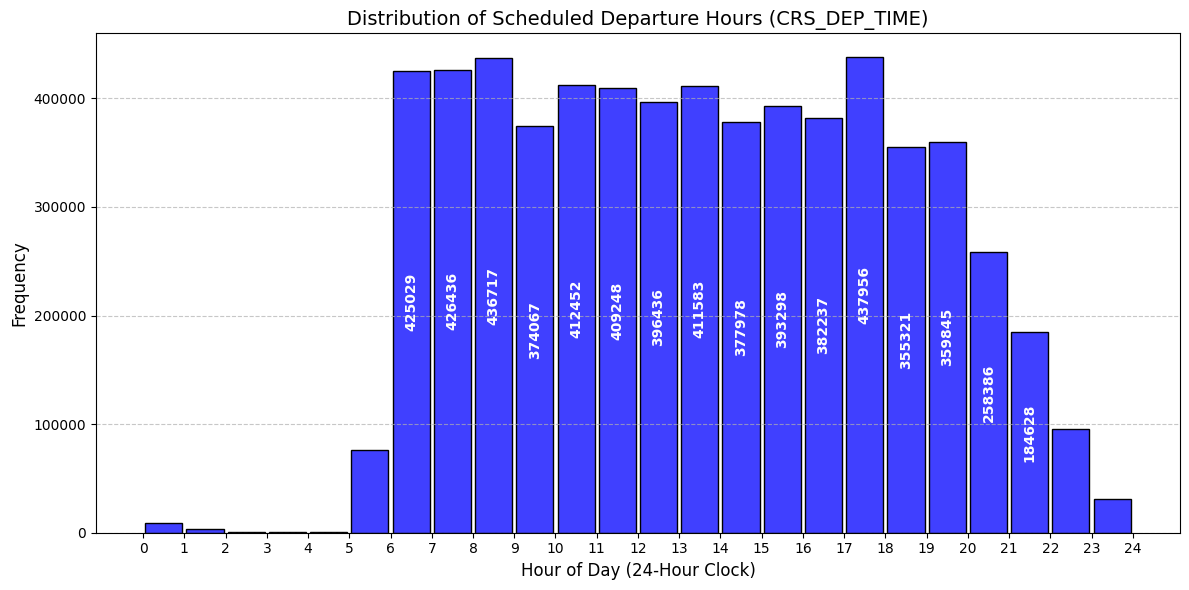

In [70]:

import matplotlib.pyplot as plt
import seaborn as sns

# Ensuring 'CRS_DEP_TIME' is in the correct string format and extracting the hour
df_cleaned['DEP_Hour'] = df_cleaned['CRS_DEP_TIME'].str.split(':').str[0].astype(int)

# Plotting the distribution of DEP_Hour
plt.figure(figsize=(12, 6))
ax = sns.histplot(
    df_cleaned['DEP_Hour'], 
    bins=range(25), 
    kde=False, 
    color='blue', 
    shrink=0.9  # Adjusts the bar width
)

# Adding text annotations inside each bar, vertically, only for counts > 100000
for p in ax.patches:
    count = int(p.get_height())  # Getting the height of each bar
    if count > 100000:  # Only annotating bars with counts over 100000
        ax.annotate(
            f'{count}',
            (p.get_x() + p.get_width() / 2., count / 2),  # Centering inside the bar
            ha='center', va='center', fontsize=10, color='white', weight='bold',
            rotation=90  # Makes the text vertical
        )


plt.title('Distribution of Scheduled Departure Hours (CRS_DEP_TIME)', fontsize=14)
plt.xlabel('Hour of Day (24-Hour Clock)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(range(0, 25))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


From this plot, it is possible to see that the distribution of planned departure time is very similar from 6:00 to 19:59. Timespan 17:00 - 17:59 had the most planned departures (437956) and it was closely followed by timespan 8:00 - 8:59 (436717 planned departures). Third most popular timespan for planned departures was 7:00 - 7:59 with 426436 planned departures. Let's classify only timespans 17:00 - 17:59 and 8:00 - 8:59 as rush hours for departures and it could be useful later.

Let's create a binary feature 'DEP_Rush_Hour' that has value 1 when scheduled departure time was in timespans 8:00 - 8:59 or 17:00 - 17:59. We can use previously defined feature 'DEP_Hour' to define this feature.

In [71]:
Rush_Hour = [8, 17]

# Create the binary feature for rush hour
df_cleaned['DEP_Rush_Hour'] = df_cleaned['DEP_Hour'].apply(lambda x: 1 if x in Rush_Hour else 0)

# Check if the feature worked
print(df_cleaned[['DEP_Hour', 'DEP_Rush_Hour']].head(20))

    DEP_Hour  DEP_Rush_Hour
0          7              0
1         22              0
2          7              0
3          7              0
4         11              0
5         11              0
6         15              0
7         20              0
8          7              0
9         21              0
10         7              0
11        16              0
12         8              1
13         8              1
14        17              1
15        23              0
16        19              0
17        21              0
18        20              0
19         9              0


Now, let's repeat the process for arrivals but now focus on actual arrival times, not scheduled arrival times. Reasoning for focusing on actual arrival times is that results from further analysis will be more realistic.

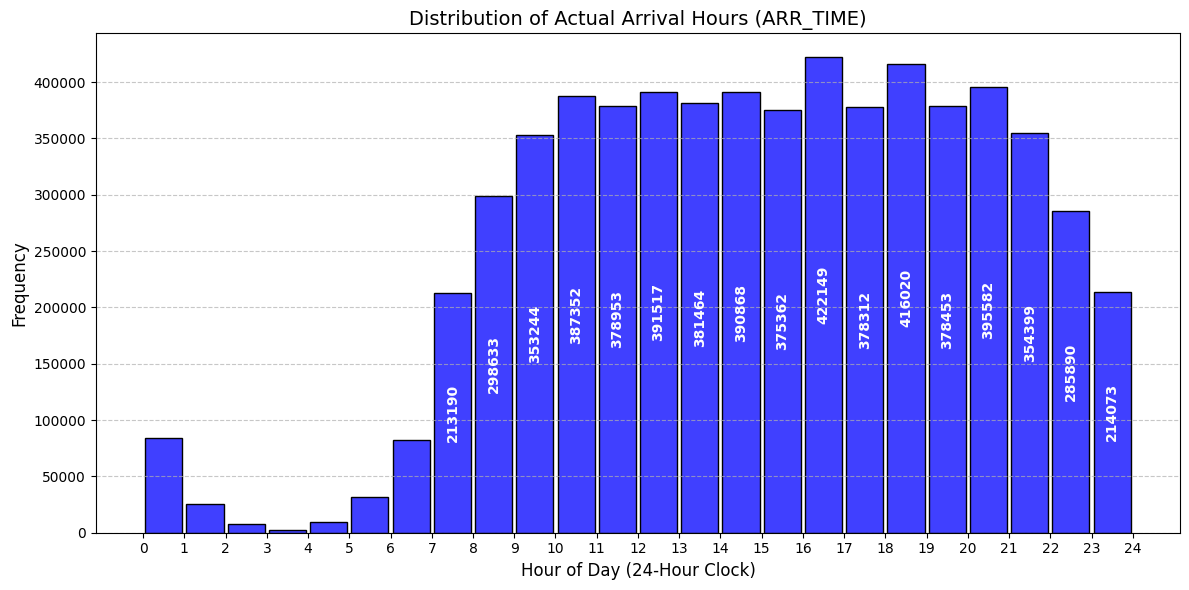

In [72]:

# Creating the 'ARR_Hour' feature, extract hour only for non-NaT values
df_cleaned['ARR_Hour'] = df_cleaned['ARR_TIME'].apply(lambda x: int(x.split(':')[0]) if pd.notna(x) else pd.NaT)



# Plotting the distribution of DEP_Hour
plt.figure(figsize=(12, 6))
ax = sns.histplot(
    df_cleaned['ARR_Hour'], 
    bins=range(25), 
    kde=False, 
    color='blue', 
    shrink=0.9  # Adjusts the bar width
)

# Adding text annotations inside each bar, vertically, only for counts > 100000
for p in ax.patches:
    count = int(p.get_height())  # Getting the height of each bar
    if count > 100000:  # Only annotating bars with counts over 100000
        ax.annotate(
            f'{count}',
            (p.get_x() + p.get_width() / 2., count / 2),  # Centering inside the bar
            ha='center', va='center', fontsize=10, color='white', weight='bold',
            rotation=90  # Makes the text vertical
        )


plt.title('Distribution of Actual Arrival Hours (ARR_TIME)', fontsize=14)
plt.xlabel('Hour of Day (24-Hour Clock)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(range(0, 25))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


From this plot, it is possible to see that the distribution of actual arrival time is very similar from 9:00 to 21:59. Timespan 16:00 - 16:59 had the most actual arrivals (422149) and it was closely followed by timespan 18:00 - 18:59 (416020 actual arrivals). Third most popular timespan for actual arrivals was 20:00 - 20:59 with 395582 planned departures. Let's classify only timespans 16:00 - 16:59 and 18:00 - 18:59 as rush hours for actual arrivals and this could be later useful.

Let's create a binary feature 'ARR_Rush_Hour' that has value 1 when actual arrival time was in timespans 16:00 - 16:59 or 18:00 - 18:59. We can use previously defined feature 'ARR_Hour' to define this feature.

In [73]:
Rush_Hour = [16, 18]

# Create the binary feature for rush hour
df_cleaned['ARR_Rush_Hour'] = df_cleaned['ARR_Hour'].apply(lambda x: 1 if x in Rush_Hour else 0)

# Check if the feature worked
print(df_cleaned[['ARR_Hour', 'ARR_Rush_Hour']].head(20))

    ARR_Hour  ARR_Rush_Hour
0         14              0
1          5              0
2         10              0
3         10              0
4         18              1
5         14              0
6         23              0
7         23              0
8         15              0
9          5              0
10        14              0
11        19              0
12        16              1
13        11              0
14        21              0
15         7              0
16        20              0
17        23              0
18        21              0
19        10              0


### Summary statistics

It is also important to make sure there are no illogical values within this dataset.

In [74]:
# Selecting only relevant numerical features for summary statistics
numerical_features = ['DEP_DELAY', 'TAXI_OUT', 'TAXI_IN', 'ARR_DELAY', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 
    'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']

# Generating descriptive statistics for numerical features
numerical_stats = df_cleaned[numerical_features].describe()

# Displaying the statistics
numerical_stats


,DEP_DELAY,TAXI_OUT,TAXI_IN,ARR_DELAY,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
count,6.259310e+06,6.259310e+06,6.259310e+06,6.259310e+06,6.259310e+06,6.259310e+06,6.259310e+06,6.259310e+06,1.269277e+06,1.269277e+06,1.269277e+06,1.269277e+06,1.269277e+06
mean,9.684819e+00,1.559238e+01,6.772477e+00,6.010872e+00,1.329942e+02,1.293203e+02,1.069554e+02,7.645784e+02,1.665271e+01,2.343187e+00,1.372976e+01,8.166145e-02,2.386873e+01
std,3.556704e+01,9.033458e+00,4.710094e+00,3.805200e+01,7.216993e+01,7.166801e+01,6.976986e+01,5.859701e+02,4.358163e+01,1.702502e+01,2.765401e+01,2.627572e+00,4.103753e+01
min,-1.710000e+02,1.000000e+00,1.000000e+00,-1.530000e+02,2.000000e+01,1.100000e+01,5.000000e+00,3.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,-5.000000e+00,1.000000e+01,4.000000e+00,-1.200000e+01,8.100000e+01,7.800000e+01,5.700000e+01,3.410000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,-1.000000e+00,1.300000e+01,6.000000e+00,-3.000000e+00,1.140000e+02,1.100000e+02,8.700000e+01,5.960000e+02,1.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,7.000000e+00
75%,9.000000e+00,1.800000e+01,8.000000e+00,1.000000e+01,1.630000e+02,1.590000e+02,1.360000e+02,9.910000e+02,1.600000e+01,0.000000e+00,1.800000e+01,0.000000e+00,3.100000e+01
max,1.975000e+03,2.370000e+02,3.460000e+02,1.983000e+03,7.000000e+02,7.380000e+02,6.950000e+02,4.983000e+03,1.975000e+03,1.591000e+03,1.287000e+03,5.730000e+02,1.182000e+03


It seems like all relevant numerical features have logical values. There are no negative values for 'AIR_TIME' and 'ACTUAL_ELAPSED_TIME' anymore. 

### Testing rush_hour metric

Here we compare the arrival delay of flights that arrived during rush hour to the delay of flights that did not arrive during rush hour.

Rush Hour Delay Comparison:
   ARR_Rush_Hour  Mean Delay  Median Delay  Std Delay    Count
0              0    5.992612          -4.0  38.492842  5421141
1              1    6.128973          -2.0  35.066926   838169


C:\Users\jaano\AppData\Local\Temp\ipykernel_24588\890668048.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


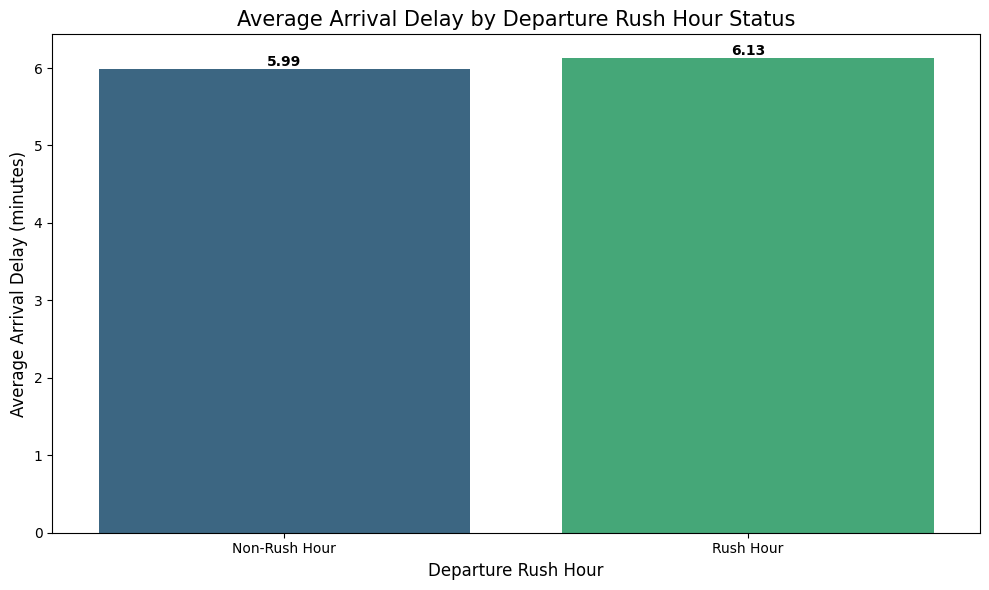


Statistical Significance Test:
T-Statistic: 3.0532333319507265
P-Value: 0.0022639078305517583
Statistically Significant Difference: Yes


C:\Users\jaano\AppData\Local\Temp\ipykernel_24588\890668048.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


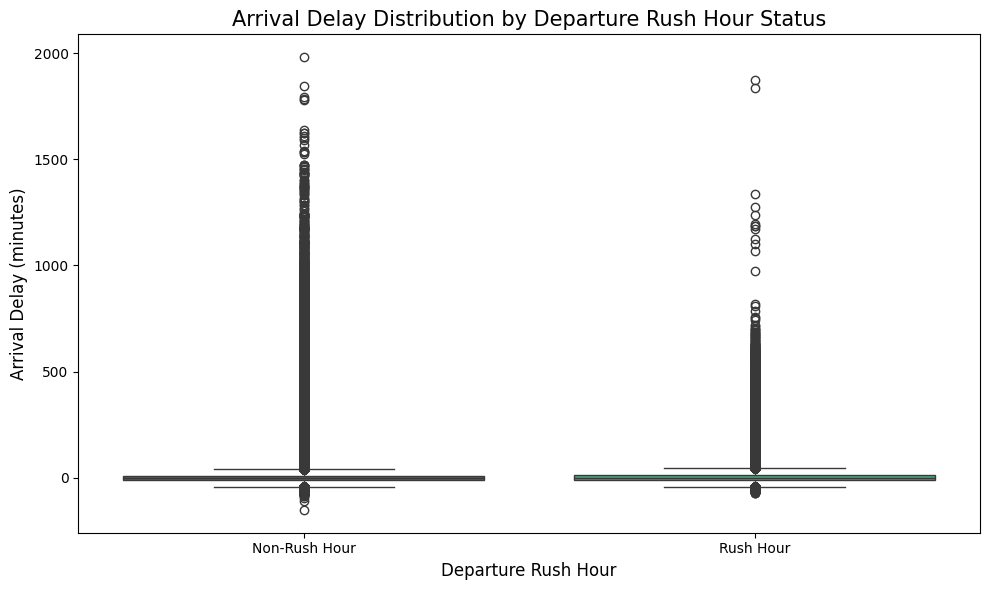

In [ ]:
# Group by ARR_Rush_Hour and calculate mean ARR_DELAY
rush_hour_delay_comparison = df_cleaned.groupby('ARR_Rush_Hour')['ARR_DELAY'].agg([
    ('Mean Delay', 'mean'),
    ('Median Delay', 'median'),
    ('Std Delay', 'std'),
    ('Count', 'count')
]).reset_index()

# Print the comparison statistics
print("Rush Hour Delay Comparison:")
print(rush_hour_delay_comparison)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x='ARR_Rush_Hour', 
    y='Mean Delay', 
    data=rush_hour_delay_comparison,
    palette='viridis'
)

plt.title('Average Arrival Delay by Departure Rush Hour Status', fontsize=15)
plt.xlabel('Departure Rush Hour', fontsize=12)
plt.ylabel('Average Arrival Delay (minutes)', fontsize=12)
plt.xticks([0, 1], ['Non-Rush Hour', 'Rush Hour'])

# Add value labels on top of each bar
for i, v in enumerate(rush_hour_delay_comparison['Mean Delay']):
    plt.text(
        i, 
        v, 
        f'{v:.2f}', 
        ha='center', 
        va='bottom',
        fontweight='bold'
    )

plt.tight_layout()
plt.show()

# Optional: Statistical significance test
from scipy import stats

# Separate delay groups
rush_hour_delays = df_cleaned[df_cleaned['ARR_Rush_Hour'] == 1]['ARR_DELAY']
non_rush_hour_delays = df_cleaned[df_cleaned['ARR_Rush_Hour'] == 0]['ARR_DELAY']

# Perform t-test
t_statistic, p_value = stats.ttest_ind(rush_hour_delays, non_rush_hour_delays)

print("\nStatistical Significance Test:")
print(f"T-Statistic: {t_statistic}")
print(f"P-Value: {p_value}")
print("Statistically Significant Difference:" + 
      " Yes" if p_value < 0.05 else " No")

# Box plot for more detailed distribution
plt.figure(figsize=(10, 6))
sns.boxplot(
    x='ARR_Rush_Hour', 
    y='ARR_DELAY', 
    data=df_cleaned,
    palette='viridis'
)

plt.title('Arrival Delay Distribution by Departure Rush Hour Status', fontsize=15)
plt.xlabel('Departure Rush Hour', fontsize=12)
plt.ylabel('Arrival Delay (minutes)', fontsize=12)
plt.xticks([0, 1], ['Non-Rush Hour', 'Rush Hour'])

plt.tight_layout()
plt.show()

Here we compare the departure delay of flights that departed during rush hour to the delay of flights that did not depart during rush hour.

Rush Hour Delay Comparison:
   DEP_Rush_Hour  Mean Delay  Median Delay  Std Delay    Count
0              0    9.729281          -1.0  35.515310  5384637
1              1    9.411104          -1.0  35.882659   874673


C:\Users\jaano\AppData\Local\Temp\ipykernel_24588\2319163501.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


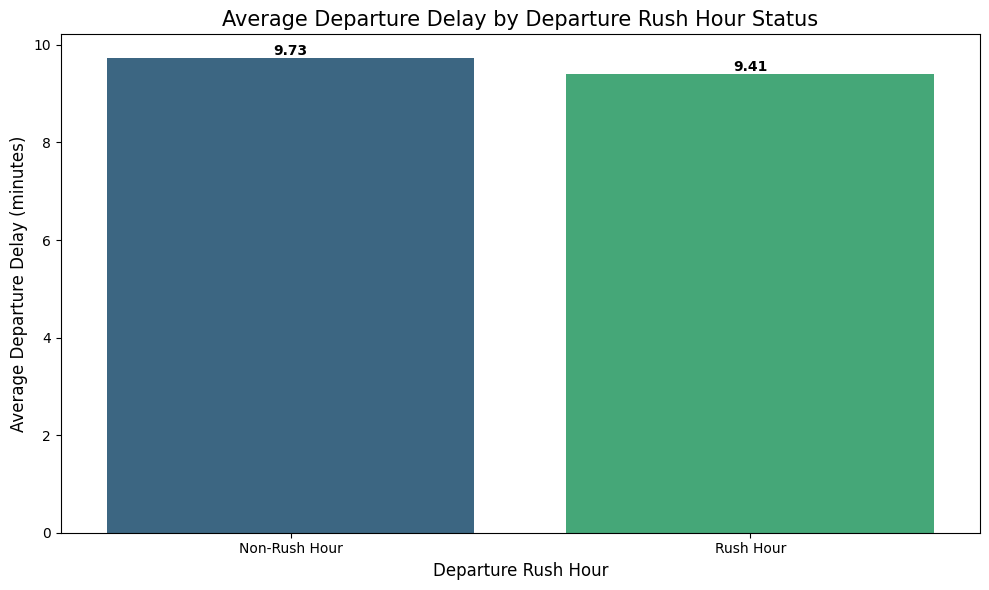


Statistical Significance Test:
T-Statistic: -7.759963369421212
P-Value: 8.496662926708594e-15
Statistically Significant Difference: Yes


C:\Users\jaano\AppData\Local\Temp\ipykernel_24588\2319163501.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


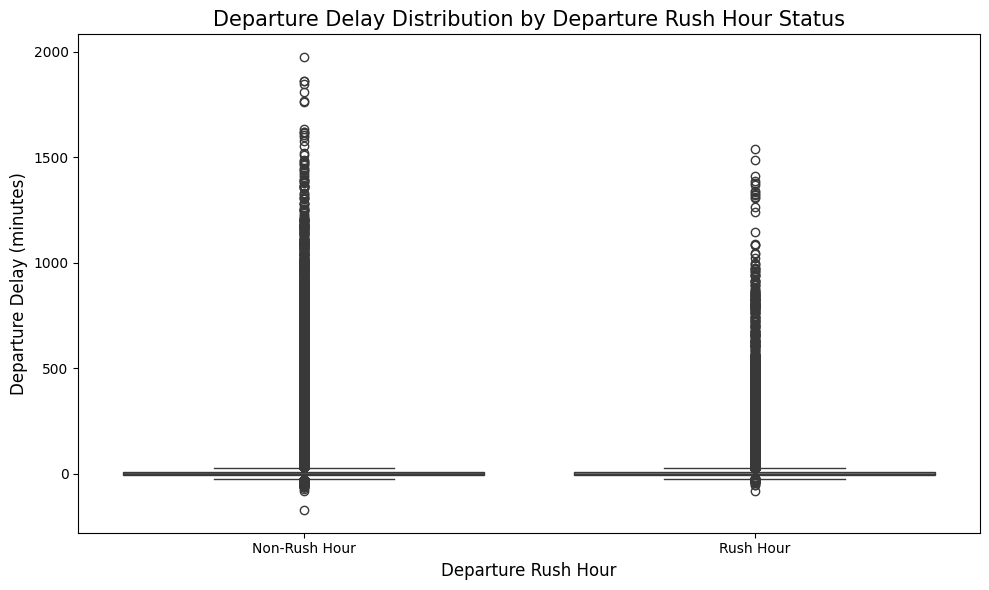

In [ ]:
# Group by DEP_Rush_Hour and calculate mean DEP_DELAY
rush_hour_delay_comparison = df_cleaned.groupby('DEP_Rush_Hour')['DEP_DELAY'].agg([
    ('Mean Delay', 'mean'),
    ('Median Delay', 'median'),
    ('Std Delay', 'std'),
    ('Count', 'count')
]).reset_index()

# Print the comparison statistics
print("Rush Hour Delay Comparison:")
print(rush_hour_delay_comparison)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x='DEP_Rush_Hour', 
    y='Mean Delay', 
    data=rush_hour_delay_comparison,
    palette='viridis'
)

plt.title('Average Departure Delay by Departure Rush Hour Status', fontsize=15)
plt.xlabel('Departure Rush Hour', fontsize=12)
plt.ylabel('Average Departure Delay (minutes)', fontsize=12)
plt.xticks([0, 1], ['Non-Rush Hour', 'Rush Hour'])

# Add value labels on top of each bar
for i, v in enumerate(rush_hour_delay_comparison['Mean Delay']):
    plt.text(
        i, 
        v, 
        f'{v:.2f}', 
        ha='center', 
        va='bottom',
        fontweight='bold'
    )

plt.tight_layout()
plt.show()

# Optional: Statistical significance test
from scipy import stats

# Separate delay groups
rush_hour_delays = df_cleaned[df_cleaned['DEP_Rush_Hour'] == 1]['DEP_DELAY']
non_rush_hour_delays = df_cleaned[df_cleaned['DEP_Rush_Hour'] == 0]['DEP_DELAY']

# Perform t-test
t_statistic, p_value = stats.ttest_ind(rush_hour_delays, non_rush_hour_delays)

print("\nStatistical Significance Test:")
print(f"T-Statistic: {t_statistic}")
print(f"P-Value: {p_value}")
print("Statistically Significant Difference:" + 
      (" Yes" if p_value < 0.05 else " No"))

# Box plot for more detailed distribution
plt.figure(figsize=(10, 6))
sns.boxplot(
    x='DEP_Rush_Hour', 
    y='DEP_DELAY', 
    data=df_cleaned,
    palette='viridis'
)

plt.title('Departure Delay Distribution by Departure Rush Hour Status', fontsize=15)
plt.xlabel('Departure Rush Hour', fontsize=12)
plt.ylabel('Departure Delay (minutes)', fontsize=12)
plt.xticks([0, 1], ['Non-Rush Hour', 'Rush Hour'])

plt.tight_layout()
plt.show()

## Wrapping up

**The data formatting is done, we will save the two dataframes into files and utilize them in the next notebooks on EDA and ML.**

In [ ]:
df_cleaned.to_csv('df_cleaned.csv', index=False)
df_cancel.to_csv('df_cancel.csv', index=False)